In [1]:
%matplotlib notebook

In [2]:
import calour as ca
from calour.training import plot_roc
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.metrics import roc_curve
from emperor import Emperor, nbinstall
ca.set_log_level(40)

/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Import Data

In [4]:
ldlr = ca.read_amplicon('../data/microbiome/ldlr-deblur-refererence-hit-2k-wtax.biom', 
                        '../data/combined_sample_metadata_HFD.txt', min_reads=100, normalize=100)

In [5]:
apoe = ca.read_amplicon('../data/microbiome/apoe-deblur-reference-hit-2k-wtax.biom',
                        '../data/combined_sample_metadata_HFD.txt', min_reads=100, normalize=100)
apoe = apoe.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

In [6]:
exp = apoe.join_experiments(ldlr)

In [7]:
exp

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 642 samples, 8648 features

# data preprocessing

Filter out OTUs low abundant in both of mouse models and the inital baseline samples (because they were fed with different diet).

In [9]:
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.000001, fraction=0.01).filter_samples('age', [10, 10.5], negate=True)
exp2

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 582 samples, 437 features

In [10]:
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 412 samples, 437 features

In [11]:
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    211
IHH    201
Name: exposure_type, dtype: int64

In [12]:
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR knockout')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

IHH    85
Air    85
Name: exposure_type, dtype: int64

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, auc

# Plot ROC curve using the abundance of each OTUs

<IPython.core.display.Javascript object>


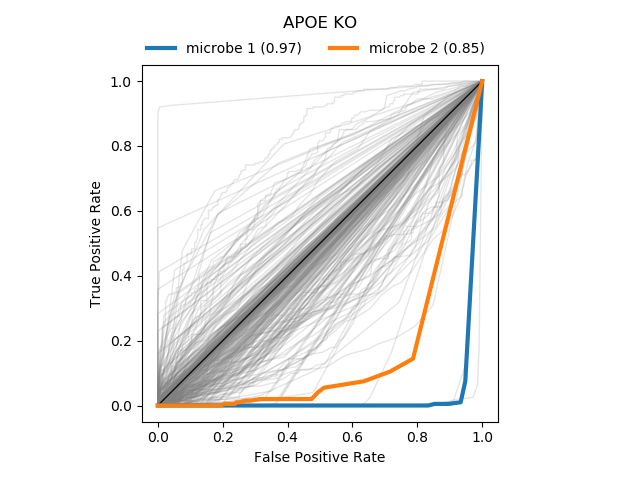

Text(0.5,1.08,'APOE KO')

In [48]:
from matplotlib import pyplot as plt
fig_apoe, ax_apoe = plt.subplots()
ax_apoe.set_aspect('equal')
fids_apoe = []
auc_apoe = []
for i in exp2_apoe.feature_metadata.index:
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.7:
        fids_apoe.append(i)
        auc_apoe.append(a)
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.2)

ax_apoe.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_apoe.set_xlim(-0.05, 1.05)
ax_apoe.set_ylim(-0.05, 1.05)
ax_apoe.set_xlabel('False Positive Rate')
ax_apoe.set_ylabel('True Positive Rate')
ax_apoe.set_title('APOE KO',  y=1.08)

<IPython.core.display.Javascript object>


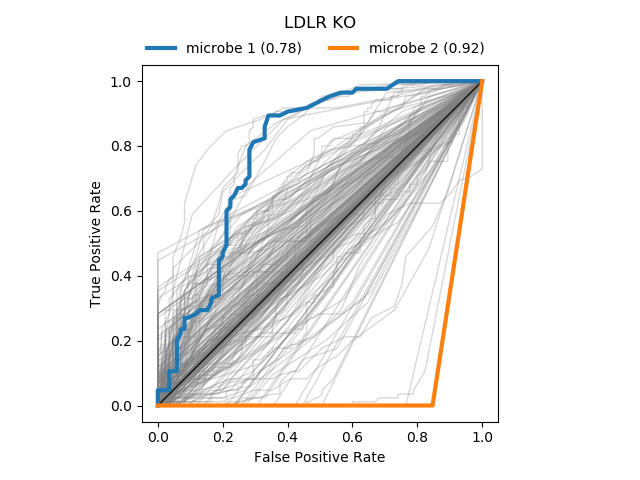

Text(0.5,1.08,'LDLR KO')

In [49]:
from matplotlib import pyplot as plt
fig_ldlr, ax_ldlr = plt.subplots()
ax_ldlr.set_aspect('equal')
fids_ldlr = []
auc_ldlr = []
for i in exp2_ldlr.feature_metadata.index:
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if a > 0.7:
        fids_ldlr.append(i)
        auc_ldlr.append(a)
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.3)

ax_ldlr.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_ldlr.set_xlim(-0.05, 1.05)
ax_ldlr.set_ylim(-0.05, 1.05)
ax_ldlr.set_xlabel('False Positive Rate')
ax_ldlr.set_ylabel('True Positive Rate')
ax_ldlr.set_title('LDLR KO',  y=1.08)

In [42]:
df1 = pd.DataFrame({'auc': auc_apoe, 'id': fids_apoe})
df2 = pd.DataFrame({'auc': auc_ldlr, 'id': fids_ldlr})

df = pd.merge(df1, df2, 'inner',  left_on='id', right_on='id', suffixes=('_ApoE', '_LDLR'))
df['sum_auc'] = df['auc_ApoE'] + df['auc_LDLR']
df['annot'] = exp2.feature_metadata.loc[df['id'], 'taxonomy'].values
df.set_index('id', inplace=True)
df.sort_values('sum_auc', ascending=False, kind='mergesort', inplace=True)

In [43]:
df

,auc_ApoE,auc_LDLR,sum_auc,annot
id,,,,
TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG,0.970845,0.923529,1.894374,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG,0.848035,0.784291,1.632325,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGCCTGCCAAGTCTGATGTGAAATACCGGGGCTCAACCCCGGGGCTGCATTGGAAACTGGCAGGCTGGAGTGCCGGAGAGGCAGGCGGAATTCCTAG,0.701327,0.829689,1.531016,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


In [53]:
df.to_csv('../figures/table.s5.microbes.tsv', sep='\t')

In [44]:
features = []
for n, i in enumerate(df.index, 1):
    df_ = pd.DataFrame({'abundance': exp2[:, i],
                       'taxonomy': 'microbe %d:' % n + exp2.feature_metadata.loc[i, 'taxonomy'],
                       'feature': i,
                       'genotype': exp2.sample_metadata['genotype'],
                       'age': exp2.sample_metadata['age'],
                       'exposure_type': exp2.sample_metadata['exposure_type']})
    #df['taxonomy'] = 
    features.append(df_)

features = pd.concat(features, axis=0)

features.to_csv('../figures/common-imp-microbes.tsv', sep='\t')

In [45]:
features.head()

,abundance,age,exposure_type,feature,genotype,taxonomy
#SampleID,,,,,,
11548.A23.119.20,3.20,19.5,Air,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,ApoE KO,microbe 1:k__Bacteria;p__Firmicutes;c__Clostri...
11548.A19.104.3,0.00,11.0,IHH,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,ApoE KO,microbe 1:k__Bacteria;p__Firmicutes;c__Clostri...
11548.A18.98.18,0.00,18.5,IHH,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,ApoE KO,microbe 1:k__Bacteria;p__Firmicutes;c__Clostri...
11548.A21.112.11,1.30,15.0,Air,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,ApoE KO,microbe 1:k__Bacteria;p__Firmicutes;c__Clostri...
11548.A21.112.8,2.65,13.5,Air,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,ApoE KO,microbe 1:k__Bacteria;p__Firmicutes;c__Clostri...


In [50]:
for n, (i, c) in enumerate(zip(df.index, plt.cm.tab10.colors), 1):
    if n > 2: continue
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_apoe.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_apoe.tight_layout()

In [51]:
for n, (i, c) in enumerate(zip(fids, plt.cm.tab10.colors), 1):
    if n > 2: continue
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_ldlr.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False,  loc="lower left")
fig_ldlr.tight_layout()

In [366]:
from matplotlib.backends.backend_pdf import PdfPages

In [377]:
with PdfPages('roc-microbes.pdf') as pdf:
    pdf.savefig(fig_apoe)
    pdf.savefig(fig_ldlr)

R code to plot the abundance trend: